In [103]:
import pandas as pd
import numpy as np
import csv
from operator import itemgetter
from Predictability import maximum_predictability
from Entropy import RealEntropy
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

%matplotlib inline

In [2]:
filenames = ['201706-citibike-tripdata.csv', '201707-citibike-tripdata.csv', '201708-citibike-tripdata.csv']
outputs = ['June.csv', 'July.csv', 'August.csv']

def to_hour(starttime):
    return starttime[8:-6].split()[1]

def to_day(starttime):
    return starttime[8:-6].split()[0]

def record_2_timeseries(record):
    return [record[r] if r in record.index else 0 for r in range(720)]

def build_series(filename):
    df = pd.read_csv(filename, usecols=[1, 3])
    df.columns = ['datetime', 'id']
    print "Loaded data \n", df.head(5)
    df['hour'] = df['datetime'].apply(lambda x: to_hour(x))
    df['day'] = df['datetime'].apply(lambda x: to_day(x))
    df['hours'] =zip(df['hour'], df['day'])
    df['hours'] = df['hours'].apply(lambda xy: int(xy[0])+(int(xy[1])-1)*24)
    df = df[['id', 'hours']]
    stations = np.unique(df['id'])
    print "\nStations and pick-up hours \n", df.head(5)
    grouped = df.groupby(['id', 'hours']).size()
    print "\nAggregated per hour per station %s\n" % stations[0], grouped.get(stations[0])[:6]
    series = map(lambda station: record_2_timeseries(grouped.get(station)), stations)
    print "\nTime series \n", series[0][:10]
    return series, stations

In [3]:
station_series = []
station_list = []
for filename, output in zip(filenames, outputs):
    print "\nProcessing ", filename
    series, stations = build_series(filename)
    station_series.append(zip(stations, series))
    station_list.append(stations)
    with open(output, 'wb') as csvfile:
        writer = csv.writer(csvfile, quoting = csv.QUOTE_ALL)
        map(lambda ind: writer.writerow([stations[ind]]+series[ind]), range(len(series)))

print "Done."


Processing  201706-citibike-tripdata.csv
Loaded data 
              datetime    id
0  2017-06-01 00:00:02   515
1  2017-06-01 00:00:13   488
2  2017-06-01 00:00:20   461
3  2017-06-01 00:00:24  2009
4  2017-06-01 00:00:33   360

Stations and pick-up hours 
     id  hours
0   515      0
1   488      0
2   461      0
3  2009      0
4   360      0

Aggregated per hour per station 72
hours
0     4
5     2
6     1
7    11
8    10
9    15
dtype: int64

Time series 
[4, 0, 0, 0, 0, 2, 1, 11, 10, 15]

Processing  201707-citibike-tripdata.csv
Loaded data 
              datetime    id
0  2017-07-01 00:00:00   539
1  2017-07-01 00:00:03   293
2  2017-07-01 00:00:08  3242
3  2017-07-01 00:00:11  2002
4  2017-07-01 00:00:15  2002

Stations and pick-up hours 
     id  hours
0   539      0
1   293      0
2  3242      0
3  2002      0
4  2002      0

Aggregated per hour per station 72
hours
1    2
5    4
6    4
7    1
8    2
9    9
dtype: int64

Time series 
[0, 2, 0, 0, 0, 4, 4, 1, 2, 9]

Processing

In [4]:
station_dict = {}
#max(zip(map(len, stat), range(len(stat))), key = lambda x: x[0])[1]
station_list = sum(map(list, station_list), [])
for station in station_list:
    if station not in station_dict:
        station_dict[station] = 1
    else:
        station_dict[station] = station_dict[station] + 1

station_list = sorted(list(np.transpose(filter(lambda kv: kv[1]==3, station_dict.items()))[0]))

In [5]:
station_series = map(lambda statser: filter(lambda s: s[0] in station_list, statser), station_series)

In [6]:
station_series = map(lambda j: sum(map(lambda i: station_series[i][j][1], range(len(station_series))), []),
                     range(len(station_list)))

In [15]:
entropies = map(RealEntropy, station_series)

In [21]:
uniques = map(lambda x: len(np.unique(x)), station_series)

In [24]:
predictabilities = map(maximum_predictability, uniques, entropies)

Predictability.py:5: RuntimeWarning: invalid value encountered in log
  return 1.0*(-x*np.log(x)-(1-x)*np.log(1-x)+(1-x)*np.log(N-1)-S*np.log(2))


In [49]:
series = sorted(zip(station_list, predictabilities, station_series), key = lambda x: x[-2])

In [77]:
series = map(list, series)

In [79]:
with open('CitiBikeSeries.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, quoting = csv.QUOTE_ALL)
    map(lambda s: writer.writerow(sum([s[:2]] + s[2:], [])), series)

In [80]:
def drawSeries(timeseries, x_label, y_label, title, legends):
    fig, ax = plt.subplots(figsize = (18, 6))
    ax.set_xlim(0, len(timeseries[0]))
    #ax.set_ylim(0, np.max(timeseries)+1)
    for series_legend in zip(timeseries, legends):
        plots = ax.plot(series_legend[0], label = series_legend[1])
    plt.xlabel(x_label, fontsize = 17)
    plt.ylabel(y_label, fontsize = 17)
    plt.title(title, fontsize = 20)
    xticks = map(lambda tick: tick.label.set_fontsize(12), ax.xaxis.get_major_ticks())
    yticks = map(lambda tick: tick.label.set_fontsize(12), ax.yaxis.get_major_ticks())
    ax.grid(True)
    leg = plt.legend(fontsize = 22, frameon= True, edgecolor = 'black')

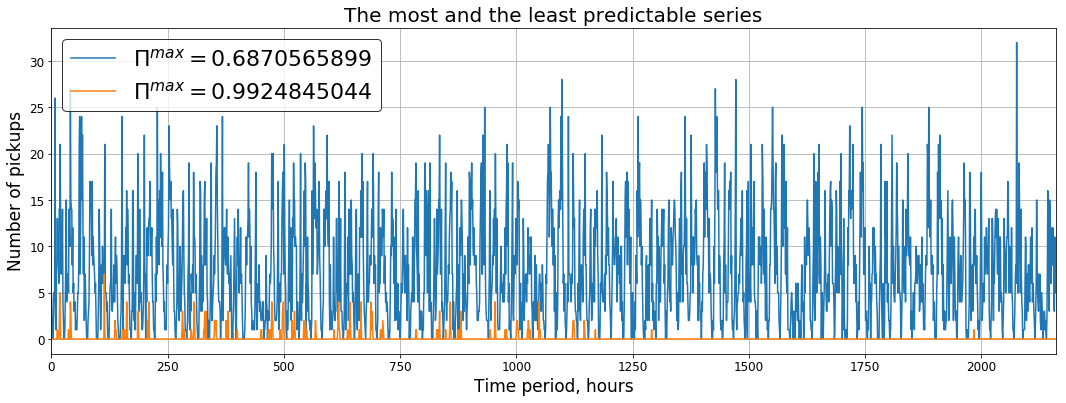

In [101]:
drawSeries([series[0][-1], series[-5][-1]], 'Time period, hours', 'Number of pickups',
           'The most and the least predictable series', 
           [r'$\Pi^{max}=$'+str(series[0][1]), r'$\Pi^{max}=$'+str(series[-5][1])])